# Texas Bridges Condition Analysis

## Table of Contents

**1. Section 1: Introducing the Dataset**
  * Section 1.1: Loading the Data
  * Section 1.2: The Variables
  <br><br>

**2. Section 2: Data Preparation**
  * Section 2.1: Bridge Age Calculation
  * Section 2.2: Removing Old Bridges
  * Section 2.3: Merging the Materials and Design Categories
  * Section 2.4: Simplifying the Dataset
  * Section 2.5: Calculating the Current Condition

    * Section 2.5.1: Drop Null Values<br>
    * Section 2.5.2: Ratings Conversion
  <br><br>
  
**3. Section 3: Exploratory Data Analysis**
  * Section 3.1: Distributions and Summary Statistics
  * Section 3.2: Analysis of Distributions
  * Section 3.3: Exploring Stations Groups
  <br><br>

**4. Section 4: Regression Modeling**
  * Section 4.1: Implementing a Simple Classification
  * Section 4.2: Evaluation using Sample Stations
  * Section 4.3: Searching for Thresholds to Balance AM and PM Peak Exits
  * Section 4.4: Conclusions

## Section 1: Introduction

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


%matplotlib inline

### Section 1.1: Loading the Dataset

The dataset has information about Texas bridges and the condition given in the most recent inspection. The aim of this report is to investigate the use of the following variables to predict the current condition of bridges:
1. Age (derived from variable Year)
2. average use (variable AverageDaily)
3. percent trucks (variable Trucks_percent)
4. material (variable Material)
5. design (variable Design)
The current condition is derived from variables Deck_rating, Superstr_rating and Substr_rating of the bridges.

We will explore: 
* How well the proposed variables can predict the bridge condition.
* Which of the proposed variables has more influence on the current condition.

### Section 1.2 The Variables
Below is an explanation of the variables we will be looking at:



| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Year           | The year the bridge was built                             | continuous | 
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Historic       | Whether the bridge is historic                            | category | 
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

 
**Values of Categorical Variables** In the original data, the values of the categorical variables are represented as integers, with their meanings given in a data dictionary. In our dataset, these 'numeric codes' have been replaced with suitable names.

| Variable      |      Values            |
|:--------------|:-----------------------|
|Historic       | Register, Possible, Unknown, Not historic |
|Service_under  | Other, Highway, Railroad, Pedestrian, Interchange, Building |
|Material       | Other, Concrete, Steel, Timber, Masonry |
|Design         | Other, Slab, Beam, Frame, Truss, Arch, Suspension, Movable, Tunnel, Culvert, Mixed |
|Deck_rating    | *Rating*: NA, Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed |
|Superstr_rating| *Rating* |
|Substr_rating  | *Rating* |  

In [2]:
# Load bridge data
bridges = pd.read_csv('tx19_bridges_sample.csv')
bridges.head(5)

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
0,000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
1,000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
2,000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
3,000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
4,000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


## Section 2: Data Preparation

### Section 2.1: Bridge Age Calculation

In this section we have calculated the age of the bridge and replaced the 'Year' column with these age values to facilitate the data analysis in later sections.

In [3]:
bridges['Year'] = 2021 - bridges['Year']
bridges.rename(columns = {'Year': 'Age'}, inplace = True)
bridges.head()

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Age,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
0,000021521-00101,District2,199,Free,Agency,Rural,Local,16,1,0,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
1,000021521-00181,District2,199,Free,Agency,Rural,Local,16,1,0,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
2,000021521-TMP20,District2,199,Free,Agency,Rural,Local,9,2,0,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
3,000021525-00012,District2,199,Free,Agency,Rural,Local,71,1,0,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
4,000021580-00092,District2,6,Free,Agency,Rural,Local,17,2,0,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


### Section 2.2: Removing Old Bridges

We are working under the assumption that old bridges are in poor condition, so we will remove them from the dataset in order not to skew the data. Below is a box-and-whiskers plot of the age of the bridges. The outliers are represented by black circles, and we will remove these from the dataset.
<br><br>
Based off a quick look at this plot, it looks like bridges roughly older than 115 years old will be removed.

<AxesSubplot:>

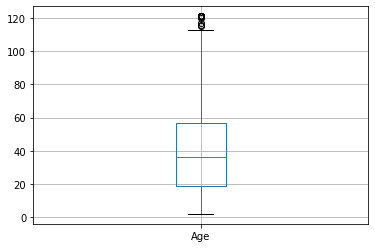

In [4]:
bridges.boxplot(column='Age')

Based off our calculations, the bridges below are outliers with respect to age and they will be removed from the dataset. 

In [5]:
Q1 = bridges['Age'].quantile(0.25)
Q3 = bridges['Age'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
bridges.loc[bridges['Age'] >= Q3 + 1.5 * IQR]

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Age,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
1732,020730AA0270001,District2,11,Free,County,Rural,Local,115,1,0,...,1,46.6,4.5,Good,Satisfactory,Good,24.5,0.0,Dry,540
7554,082090AA0188001,District8,16,Free,County,Rural,Local,121,1,0,...,1,94.8,4.1,Failed,Failed,Failed,0.0,0.0,Critical,1
8330,090500AA0274001,District9,18,Free,County,Rural,Local,121,1,0,...,1,8.8,4.9,Good,Satisfactory,Fair,10.0,0.0,Stable,65
8342,090500C00175001,District9,2,Free,Town or City,Urban,Local,117,1,0,...,1,43.0,4.5,Satisfactory,Poor,Satisfactory,0.0,0.0,Stable,365
8472,090740AA0236001,District9,6,Free,County,Rural,Local,121,1,0,...,1,21.6,3.6,Failing,Failing,Failing,0.0,0.0,Unstable,75
8591,090980AA0238002,District9,6,Free,County,Rural,Local,121,1,0,...,5,24.4,4.8,Good,Satisfactory,Fair,10.9,0.0,Stable,50
8594,090980AA0266001,District9,6,Free,County,Rural,Local,121,1,0,...,1,23.5,4.8,Fair,Poor,Satisfactory,0.0,0.0,Stable,50
9489,091610B00331001,District9,2,Free,Town or City,Urban,Minor,120,2,0,...,1,172.8,6.6,Very Good,Fair,Satisfactory,32.7,0.0,Critical,4850
17393,130760AA0189001,District13,10,Free,County,Rural,Local,121,1,0,...,1,37.2,3.5,Good,Satisfactory,Satisfactory,20.0,0.0,Stable,200
18886,140280AA0155001,District14,11,Free,County,Rural,Local,121,1,0,...,1,11.3,3.9,Very Good,Satisfactory,Fair,24.5,0.0,Stable,120


In [6]:
bridges = bridges.loc[bridges['Age'] <= Q3 + 1.5 * IQR]
bridges.sort_values('Age')

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Age,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
23946,170210AA0121004,District17,16,Free,County,Rural,Local,2,2,0,...,1,22.9,7.0,Very Good,Very Good,Very Good,32.7,0.0,Unknown,100
28460,180710004804524,District18,2,Free,State,Urban,Interstate,2,6,0,...,3,73.2,34.1,Good,Very Good,Very Good,32.7,19.0,Unknown,51300
23943,170210AA0117002,District17,159,Free,County,Rural,Local,2,2,0,...,1,22.9,7.0,Very Good,Very Good,Very Good,32.7,0.0,Unknown,75
24327,170940AA0237001,District17,6,Free,County,Rural,Local,2,1,0,...,1,9.1,4.7,Very Good,Good,Good,32.7,0.0,Unknown,150
25078,172390C00040002,District17,2,Free,Town or City,Rural,Local,2,2,0,...,1,22.9,6.9,Very Good,Very Good,Very Good,32.7,0.0,Unknown,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18908,140280B00180001,District14,2,Free,Town or City,Urban,Minor,112,2,0,...,1,10.4,7.9,Good,Good,Fair,24.5,0.0,Stable,800
27388,1805709HP230001,District18,2,Free,Town or City,Urban,Local,113,2,0,...,1,9.1,12.7,Satisfactory,Satisfactory,Satisfactory,24.5,0.0,Stable,4626
27365,1805709H0360001,District18,2,Free,Town or City,Urban,Local,113,2,0,...,1,9.4,9.1,Good,Good,Satisfactory,24.5,1.0,Stable,23600
29435,181750B01045001,District18,3,Free,Town or City,Urban,Local,113,1,0,...,1,9.8,4.5,Satisfactory,Satisfactory,Satisfactory,5.4,0.0,Stable,200


Delete?:

Text(0, 0.5, 'Number of Bridges')

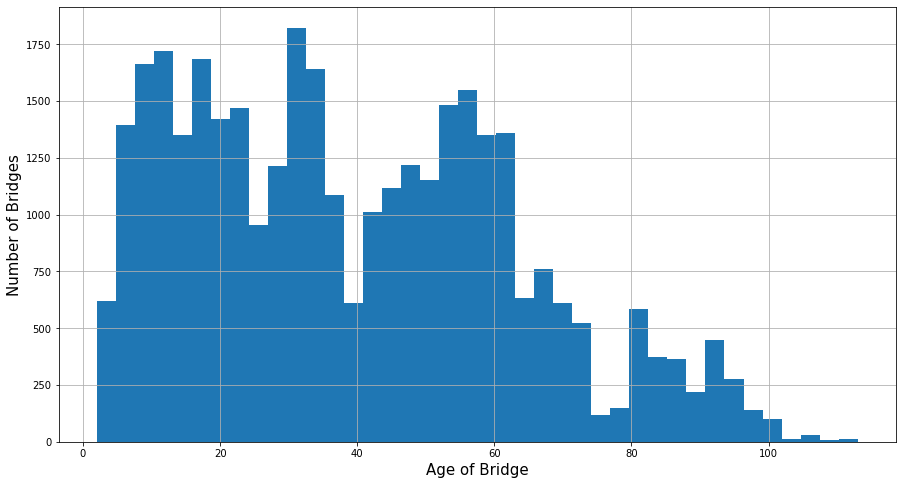

In [7]:
age_hist = bridges['Age'].hist(bins=40, figsize=(15,8))
plt.xlabel('Age of Bridge', fontsize=15)
plt.ylabel('Number of Bridges', fontsize=15)

### Section 2.3: Merging Materials and Design Categories

Some of the categories in the Materials and Design are very uneven, so we will group the smaller categories together to try to reduce the discrepancy. 

Based off the table below which lists the types of material and the number of bridges per type, Timber, Other, and Masonry are the smallest categories so these will be merged as 'Other'. We will add this simplified classification as an additional column called 'Simp_Material'.

In [8]:
# see which catergories can merged
bridges['Material'].value_counts().to_frame()

,Material
Concrete,27126
Steel,6625
Timber,465
Other,48
Masonry,13


For the Design attribute, Arch, Frame, Truss, Movable, Other, and Suspension are small catergories compared to the rest, so these will be merged under 'Other'. This simplified classification will be saved as 'Simp_Design'.

In [9]:
bridges['Design'].value_counts().to_frame()

,Design
Beam,28324
Slab,4339
Other,1244
Arch,159
Truss,125
Frame,68
Movable,13
Suspension,5


In [10]:
# define new ordinal type for the simplified material category
simp_material = pd.CategoricalDtype(categories=['Concrete', 'Steel', 'Other'])
simp_design_type = pd.CategoricalDtype(categories=['Beam', 'Slab', 'Other'], ordered=True)

# create a dictionary mapping existing to new values
simp_material_dict = {'Other':'Other', 'Masonry':'Other', 'Timber':'Other'}
simp_design_dict = {'Other':'Other', 'Arch':'Other', 'Frame':'Other', 'Movable':'Other', 'Truss':'Other',
          'Suspension':'Other'}

# define a function we can apply to map the values
def simpleMaterial(row):
    if row.Material in simp_material_dict:
        return simp_material_dict[row.Material]
    return row.Material

def simpleDesign(row):
    if row.Design in simp_design_dict:
        return simp_design_dict[row.Design]
    return row.Design
        
# Apply function
simp_material = bridges.apply(simpleMaterial, axis=1)
simp_design = bridges.apply(simpleDesign, axis=1)

# Create a dataframe of the simplified materials
simp_material = pd.DataFrame(simp_material)
simp_material.columns = ['Simp_Material']

simp_design = pd.DataFrame(simp_design)
simp_design.columns = ['Simp_Design']

# Assign simp_materials df as a column
bridges = bridges.join(simp_material)
bridges = bridges.join(simp_design)

bridges

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Age,Lanes_on,Lanes_under,...,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Simp_Material,Simp_Design
0,000021521-00101,District2,199,Free,Agency,Rural,Local,16,1,0,...,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,Concrete,Slab
1,000021521-00181,District2,199,Free,Agency,Rural,Local,16,1,0,...,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,Concrete,Slab
2,000021521-TMP20,District2,199,Free,Agency,Rural,Local,9,2,0,...,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,Concrete,Beam
3,000021525-00012,District2,199,Free,Agency,Rural,Local,71,1,0,...,3.7,Good,Good,Poor,10.0,0.0,Dry,120,Other,Beam
4,000021580-00092,District2,6,Free,Agency,Rural,Local,17,2,0,...,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,Concrete,Beam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34288,DAPFORHOO000012,District9,0,Free,Military,Urban,Local,27,3,0,...,19.0,Good,Good,Good,64.3,40.0,No waterway,600,Concrete,Beam
34289,DAPFORHOO000013,District9,0,Free,Military,Urban,Local,21,2,0,...,10.8,Good,Good,Good,35.1,40.0,No waterway,600,Concrete,Beam
34290,DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,25,2,7,...,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,Concrete,Beam
34291,DAPFORHOO00005A,District9,0,Free,Military,Urban,Local,30,2,0,...,10.4,Good,Good,Satisfactory,53.3,15.0,Stable,300,Concrete,Beam


### Section 2.4: Simplifying the Dataset

Since we are only looking at five variables in this investigation, we'll drop the other variables so that other dataset is easier to work with.

In [11]:
bridges = bridges[['Age', 'AverageDaily', 'Trucks_percent', 'Deck_rating', 'Superstr_rating', 'Substr_rating', 'Simp_Material', 'Simp_Design']]

In [12]:
bridges.head()

,Age,AverageDaily,Trucks_percent,Deck_rating,Superstr_rating,Substr_rating,Simp_Material,Simp_Design
0,16,1,0.0,Good,Very Good,Very Good,Concrete,Slab
1,16,1,0.0,Good,Good,Very Good,Concrete,Slab
2,9,100,0.0,Very Good,Very Good,Very Good,Concrete,Beam
3,71,80,0.0,Good,Good,Poor,Other,Beam
4,17,150,4.0,Good,Very Good,Very Good,Concrete,Beam


### Section 2.5: Calculating the Current Condition

In this section, we'll calculate the current condition of the bridge by adding 'Deck_rating', 'Supstr_rating', 'Substr_rating' together. However, as seen below, some null values are present in the ratings columns. Without these values, we'll have an incomplete picture of those specific bridges' current condition. Since there are only a handful of null values, they'll be dropped from the analysis.

#### Section 2.5.1: Drop Null Values

In [13]:
bridges[bridges.isnull().any(axis=1)]

,Age,AverageDaily,Trucks_percent,Deck_rating,Superstr_rating,Substr_rating,Simp_Material,Simp_Design
367,51,7520,2.0,NaN,Good,Good,Concrete,Beam
1874,75,340,0.0,Good,NaN,Fair,Steel,Beam
4668,13,20,0.0,NaN,Very Good,Very Good,Concrete,Other
15698,13,100,0.0,NaN,Good,Good,Concrete,Other
18018,22,60,0.0,NaN,Very Good,Good,Steel,Other
29605,30,160,16.0,NaN,Good,Good,Concrete,Other
31765,61,50,0.0,Failing,NaN,Poor,Concrete,Other


In [14]:
# drop null values
bridges = bridges.dropna()

#### Section 2.5.2: Ratings Conversion

Now that the null values have been dropped, we can convert the ratings to integer values and add them so it's easier to analyze. As mentioned before, we;ll obtain the current condition by adding 'Deck_rating', 'Supstr_rating', 'Substr_rating' together, and we'll use these newly calculated values to replace 'Deck_rating', 'Supstr_rating', 'Substr_rating'.

In [15]:
# set up dictionary to replace categorical rating with an integer
convert_ratings = {'Deck_rating': {"Failed": 0, "Failing": 1, "Critical": 2, "Serious": 3, "Poor": 4, 
                                  "Fair": 5, "Satisfactory": 6, "Good": 7, "Very Good": 8, 
                                   "Excellent": 9},
                   'Superstr_rating': {"Failed": 0, "Failing": 1, "Critical": 2, "Serious": 3, "Poor": 4, 
                                  "Fair": 5, "Satisfactory": 6, "Good": 7, "Very Good": 8, 
                                   "Excellent": 9}, 
                  'Substr_rating': {"Failed": 0, "Failing": 1, "Critical": 2, "Serious": 3, "Poor": 4, 
                                  "Fair": 5, "Satisfactory": 6, "Good": 7, "Very Good": 8, 
                                   "Excellent": 9}}

In [16]:
# convert ratings and sanity check .head() 
bridges = bridges.replace(convert_ratings)

# Add current condition to bridges, delete indiv ratings
bridges['Curr_Cond'] = bridges.Deck_rating + bridges.Superstr_rating + bridges.Substr_rating
bridges.drop(columns = ['Deck_rating', 'Superstr_rating', 'Substr_rating'], inplace=True)

bridges.head(10)

,Age,AverageDaily,Trucks_percent,Simp_Material,Simp_Design,Curr_Cond
0,16,1,0.0,Concrete,Slab,23
1,16,1,0.0,Concrete,Slab,22
2,9,100,0.0,Concrete,Beam,24
3,71,80,0.0,Other,Beam,18
4,17,150,4.0,Concrete,Beam,23
5,16,150,4.0,Concrete,Beam,24
6,4,20,0.0,Other,Beam,23
7,71,10,0.0,Other,Beam,14
8,71,40,0.0,Other,Beam,18
9,71,40,0.0,Other,Beam,18


## Section 3: Exploratory Data Analysis

### Section 3.1: Age, Average Use, Average Truck Crossings, Current Condition

#### Section 3.1.1: Summary Stats

Based off the table and histograms below, we see the following: <br>
* The histogram of the current condition scores looks *roughly* normal. The average score is about 20.302 and the standard deviation is about 1.999. Additionally, the 25% percentile is at 19.000 and the 50% percentile is at 21.000. Taken together, the summary statistics and histogram imply that overall the current condition scores are clustered on the higher end. The spread of the scores is low.  
* The histogram of the percent of trucks per day is strongly skewed positively, and 13% is the 75th percentile. So, most of the bridges have a low percent of trucks crossing every day. However, the maximum percent value for this attribute is 99%, so of course there are some outlier bridges with a high percent of trucks crossing.
* The histogram of Average Daily Use is also strongly skewed positively, meaning that average crossings are on the lower range, and that there is a low number of bridges with a relatively high number of crossings per day.
* While the distribution of bridge ages is uneven, it is slightly skewed positively, so we can infer there are more new bridges than older bridges.

In [17]:
bridges.describe()

,Age,AverageDaily,Trucks_percent,Curr_Cond
count,34270.000000,34270.000000,34270.000000,34270.000000
mean,39.465334,11635.098249,8.581792,20.302159
std,23.802371,24237.309917,10.348445,1.999198
min,2.000000,0.000000,0.000000,0.000000
25%,19.000000,330.000000,0.000000,19.000000
50%,36.000000,3290.000000,5.000000,21.000000
75%,57.000000,11870.000000,13.000000,22.000000
max,113.000000,543000.000000,99.000000,27.000000


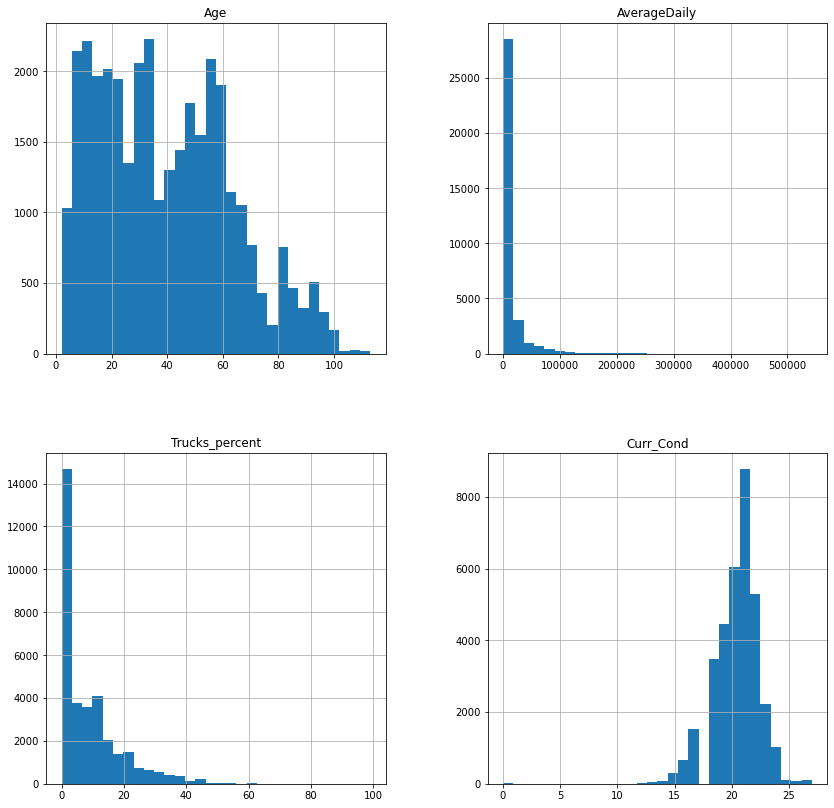

In [19]:
# look at distribution of continuous variables
ax = bridges.hist(bins=30, figsize=(14,14), layout=(2,2))

#### Section 3.1.2: Correlation Matrix

In further exploring the effect of the predictor variables on the current condition, it looks like age has the largest effect on current condition as show by the correlation matrix below. The correlation coefficient of age with respect to current condition is -0.59 shows a moderately negative correlation. So, as age increases, the current condition of the bridge moderately decreases.

Average daily cars and percent of traffic made up of trucks have correlation coefficients of 0.038 and -0.045, respectively. The results of the matrix suggest these two predictor variables do not have a large effect on the current condition of the bridge.

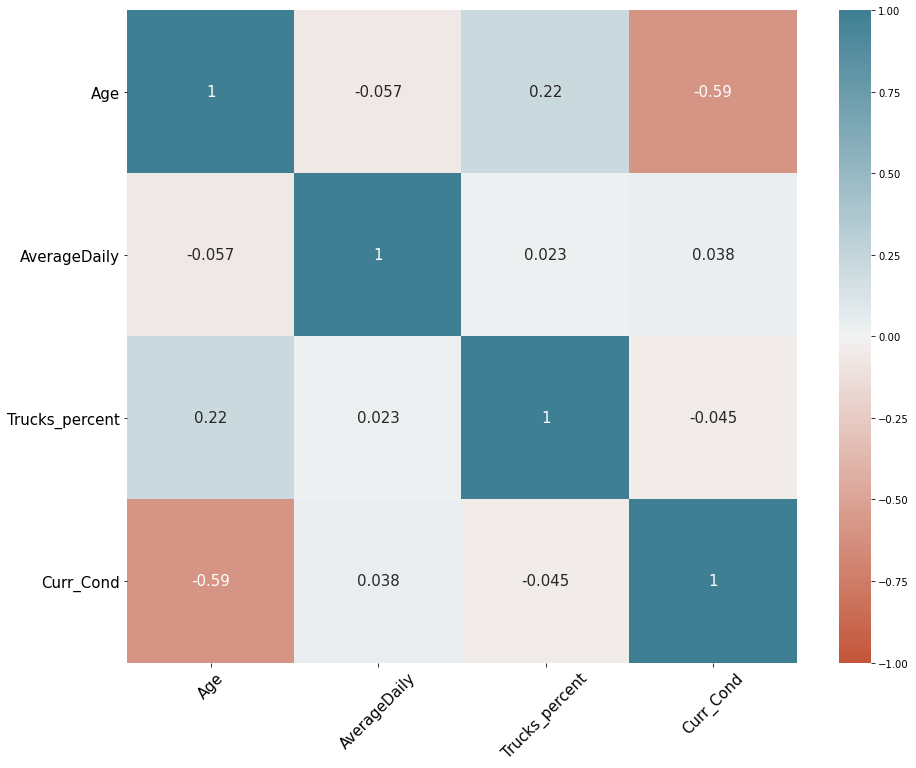

In [20]:
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(bridges.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

#### Section 3.1.3: Analysis of Age, Average Daily, and Percent of Trucks with Respect to Current Condition

* Overall, the first plot shows us most bridges are in moderately good condition across all ages since the current condition scores seems to hold above 15. However, the intensity of the hexagon colors shows us there are more young bridges with higher scores than older bridges. Additionally, it looks like the newest bridges have higher score than all the rest, seeing as the these bridges reach the mid-twenties scores. 

* The second and third plots don't show a strong relationship between current condition and average daily or percent of trucks, which agrees with the correlation matrix conclusion in the previous section.  

<AxesSubplot:xlabel='Trucks_percent', ylabel='Curr_Cond'>

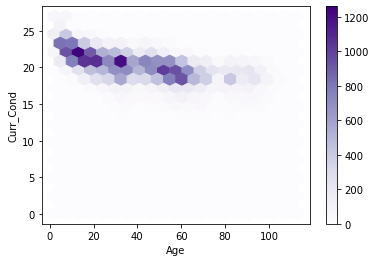

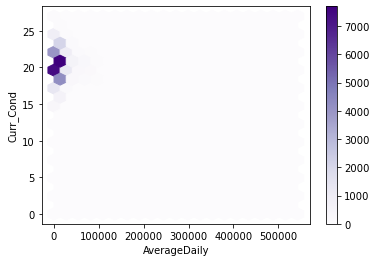

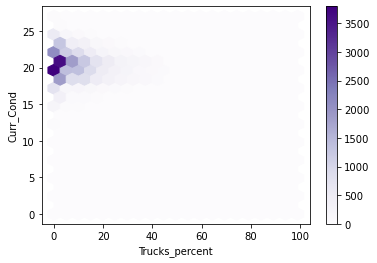

In [56]:
bridges.plot(kind='hexbin',  x='Age', y='Curr_Cond', cmap='Purples', gridsize=20, sharex=False)
bridges.plot(kind='hexbin',  x='AverageDaily', y='Curr_Cond', cmap='Purples', gridsize=20, sharex=False)
bridges.plot(kind='hexbin',  x='Trucks_percent', y='Curr_Cond', cmap='Purples', gridsize=20, sharex=False)

### Section 3.2: Comparing Materials and Design

The table below gives the probability of bridge material given bridge design. The probability a bridge is made of concrete given the design is beam is 76.64%. 

In [22]:
mat_given_design = pd.crosstab(bridges.Simp_Design, [bridges.Simp_Material], normalize='index')
mat_given_design.round(4) * 100

Simp_Material,Concrete,Other,Steel
Simp_Design,,,
Beam,76.64,1.64,21.72
Other,66.87,3.85,29.27
Slab,100.00,0.00,0.00


Probability of material given design. Probability it is concrete given the design is beam is 76.64%

In [23]:
design_given_mat = pd.crosstab(bridges.Simp_Material, [bridges.Simp_Design], normalize='index')
design_given_mat.round(4) * 100

Simp_Design,Beam,Other,Slab
Simp_Material,,,
Concrete,80.03,3.97,16.0
Other,88.21,11.79,0.0
Steel,92.89,7.11,0.0


### Section 3.3: Comparing Current Condition and Age to Materials and Design

We see the following observations when comparing age and current condition to materials and bridge design: 
* There is no obvious difference in current condition between different types of materials used or bridge design.
* Most bridges are in moderately good condition across the different materials and designs as seen by the 25% percentile being at or slightly above 15.
* Beam, slab, and other designs have been evenly used across the years.
* Concrete and steel have been used across the years as well, however, other materials began to be incorporated starting less than 80 years ago. 
  * In future analyses, it could be interesting to disaggregrate the 'Other' materials category to see which material usage is newer.

Text(0, 0.5, 'Age')

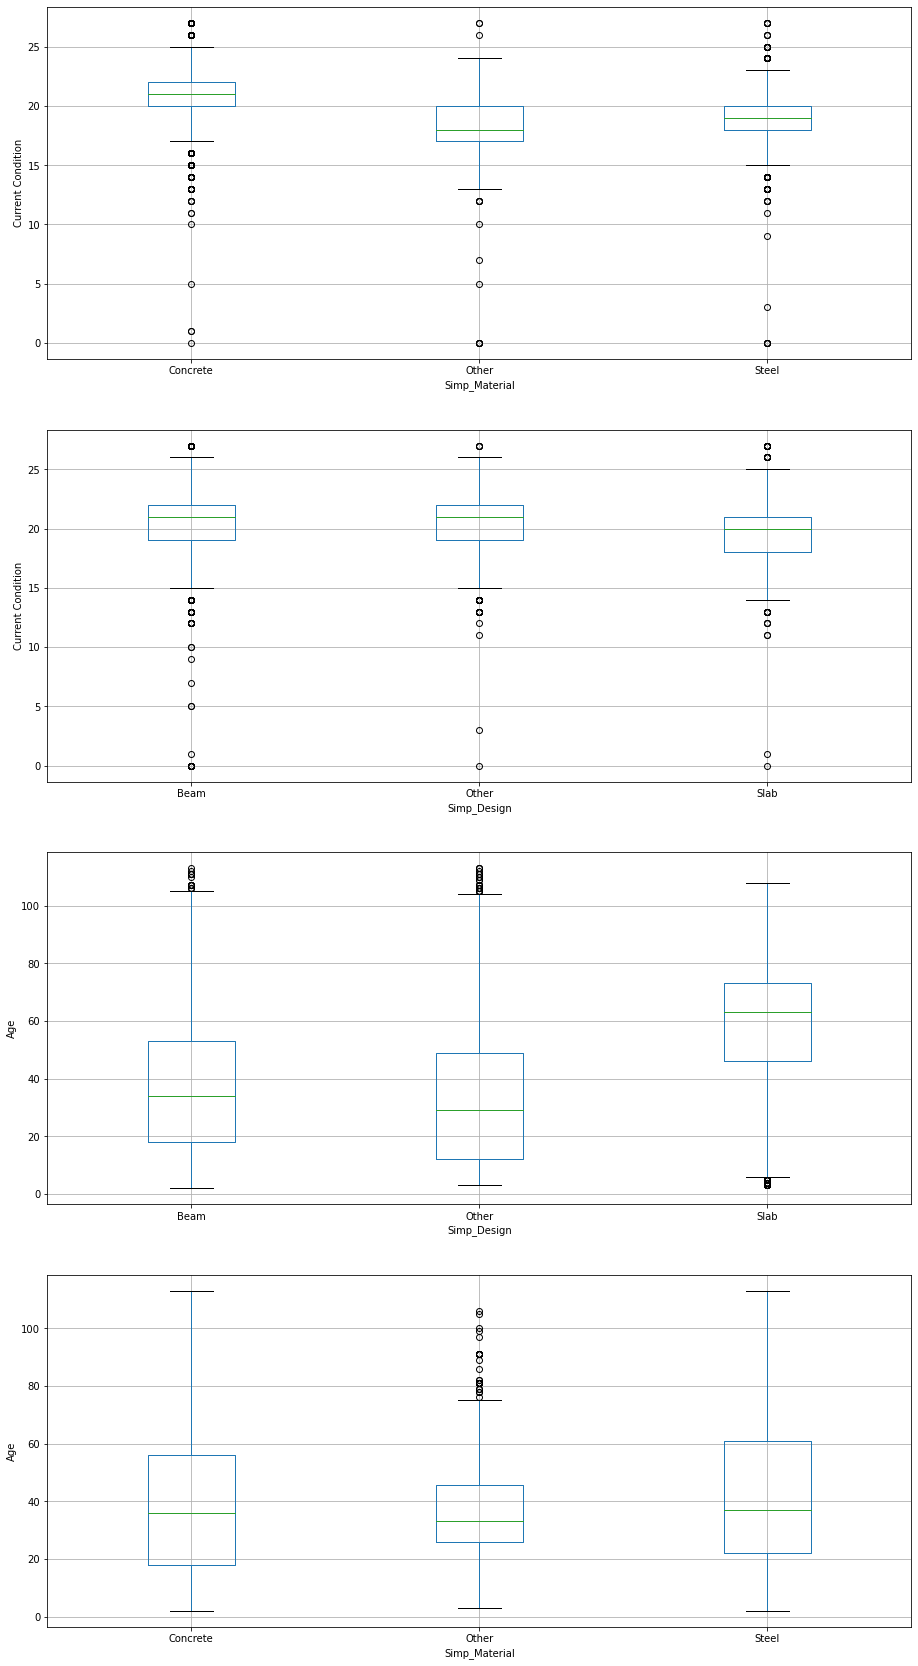

In [24]:
fig, (a1, a2, a3, a4) = plt.subplots(4,1, figsize=(15,30))

bridges.boxplot(column='Curr_Cond', by='Simp_Material', ax=a1)
bridges.boxplot(column='Curr_Cond', by='Simp_Design', ax=a2)
bridges.boxplot(column='Age', by='Simp_Design', ax=a3)
bridges.boxplot(column='Age', by='Simp_Material', ax=a4)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2, a3, a4]]
a1.set_ylabel('Current Condition')
a2.set_ylabel('Current Condition')
a3.set_ylabel('Age')
a4.set_ylabel('Age')

We see the following when comparing average daily traffic to materials and bridge design: 
* Average daily traffic is similarly distributed among bridges with difference designs.
* Average daily traffic is similarly distributed among bridges made of concrete and steel, but there seems to be less traffic on bridges made of other materials. 

In [45]:
brd_logs = bridges.assign(AverageDailyLog = np.log10(bridges.AverageDaily))

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Average Daily')

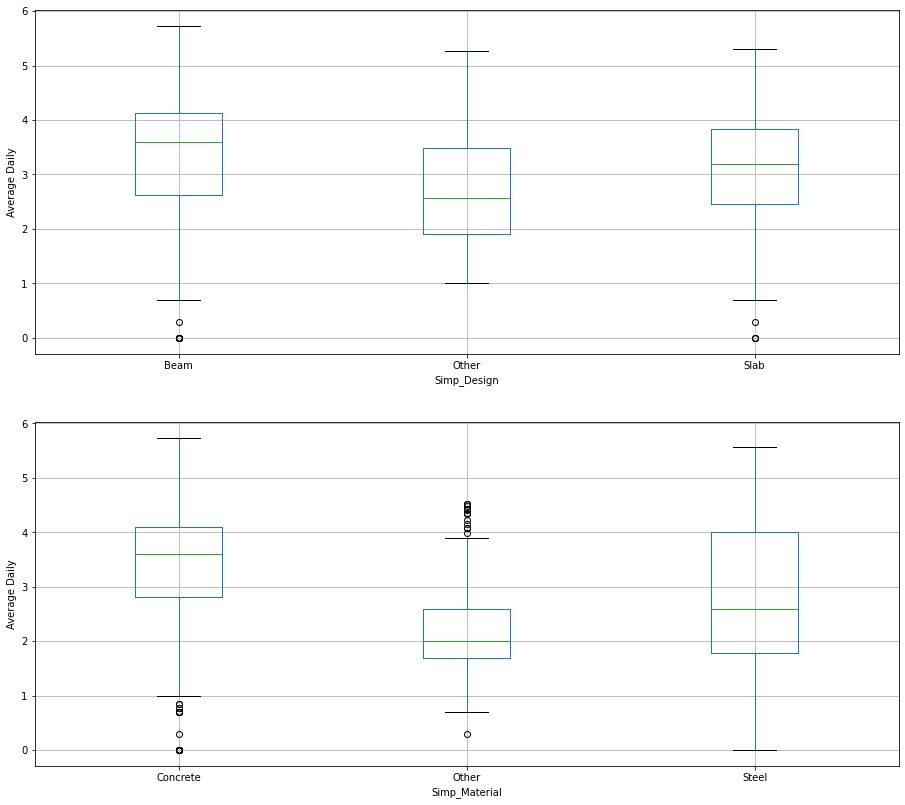

In [44]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

brd_logs.boxplot(column='AverageDailyLog', by='Simp_Design', ax=a1)
brd_logs.boxplot(column='AverageDailyLog', by='Simp_Material', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Average Daily')
a2.set_ylabel('Average Daily')

## Section 4: Regression Fitting and Conclusions

*get dummy variables for design <br>
get dummy variables for materials <br>
np column stack, then linear regression <br>
that will give us R2 and parameters* <br>
compare regression coefficients and parameters<br><br>

plot versus actual (north america)<br>
plot distribution of error and explain<br>

range of coefficients

In [57]:
# Make dummy variables
materials_dummy = pd.get_dummies(bridges.Simp_Material, drop_first=True)
design_dummy = pd.get_dummies(bridges.Simp_Design, drop_first=True)

# Define y
y = bridges['Curr_Cond']

In [31]:
# Fitting the regression line
X = np.column_stack((bridges.Age, bridges.AverageDaily, bridges.Trucks_percent, materials_dummy.Other, 
                     materials_dummy.Steel, design_dummy.Other, design_dummy.Slab))
reg = LinearRegression().fit(X, y)

beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_materials_other, beta_materials_steel, beta_design_other, beta_design_slab = reg.coef_

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
print('The regression coefficients are:', reg.coef_)

The R2 coefficient of determination is 0.451
The intercept is 22.5
The regression coefficients are: [-4.84860748e-02 -6.56576675e-07  5.15163119e-03 -2.78883680e+00
 -1.37744966e+00  1.40239492e-01 -7.58967573e-02]


The R2 coefficient of this model is 0.451, which tells us the variables we are looking at have a low-moderate effect on the current condition of the bridge, so these may not be best predictors.

The analysis also shows us the relative effect of the predictors. For example, Other materials have more of a negative impact on the current condition than steel and concrete. In terms of the effect of different bridge designs, Other bridge designs have more of a negative impact than slab or beam bridges. Since these are categorical variables, they can only be compared to other categories within the same variable. In this case, we are unable to compare the effect of these predictors to the other predictors. For example, we cannot compare the effect of beam bridges to the percent of truck crossings.

In [58]:
# Get range of predictors
age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
averagedaily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
truckspercent_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
curr_cond_range = bridges.Curr_Cond.quantile(0.9) - bridges.Curr_Cond.quantile(0.1)

# Change in the target values as a percentage of its range
print ('The change in Current Condition (as a percent of its range) given by the bridge age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * age_range) / curr_cond_range))

print ('The change in Current Condition (as a percent of its range) given by the average daily car coefficient (over its range) is %4.1f percent'
       % (100 * (beta_AverageDaily * averagedaily_range) / curr_cond_range))

print ('The change in Current Condition (as a percent of its range) given by the percent of vehicles as trucks (over its range) is %4.1f percent'
       % (100 * (beta_Trucks_percent * truckspercent_range) / curr_cond_range))

The change in Current Condition (as a percent of its range) given by the bridge age coefficient (over its range) is -59.2 percent
The change in Current Condition (as a percent of its range) given by the average daily car coefficient (over its range) is -0.4 percent
The change in Current Condition (as a percent of its range) given by the percent of vehicles as trucks (over its range) is  2.4 percent


However, we can compare the relative effects of bridge age, average daily car crossing, and percent of vehicles as trucks. This analysis finds that of these three predictors, age has the largest effect on the condition of the bridge. Changes in daily traffic and percentage of trucks have a much lower effect of the bridge condition as compared to the age.

### Error Distribution

The histogram belows shows the distribution of the error is normal and the median seems close to zero. This tells us that the linear regression model is appropriate for this data set. 

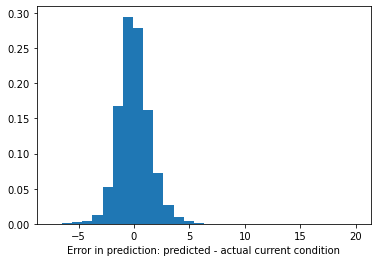

In [34]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=30, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

Text(0, 0.5, 'Actual Value')

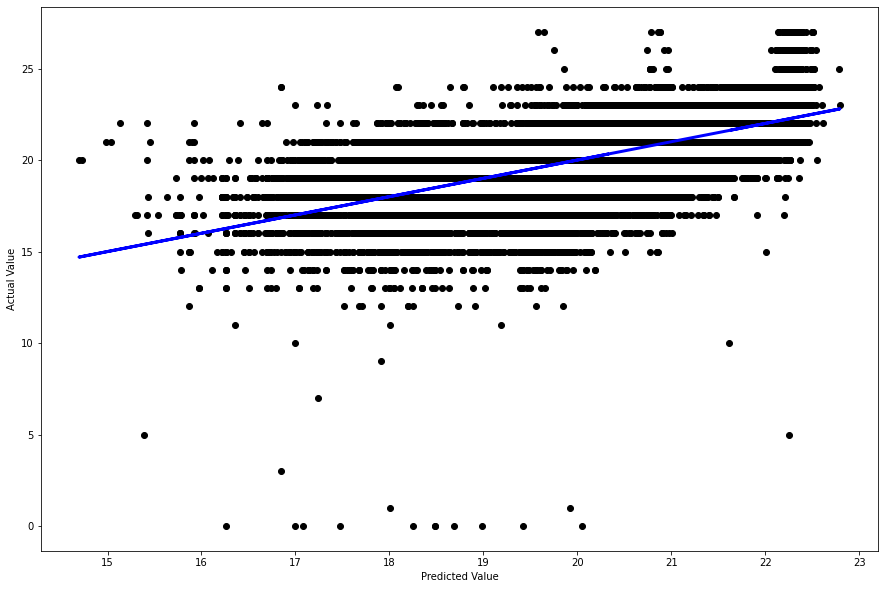

In [35]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')